# Árvore Geradora Mínima entre hospitais de Natal: aplicação do algoritmo de Kruskal

Este notebook apresenta uma solução para criar uma árvore geradora mínima (MST, do inglês *Minimum Spanning Tree*) entre hospitais da cidade de Natal, RN, Brasil. Para tanto, faz-se uso do algoritmo de Kruskal e da biblioteca OSMnx, que permite trabalhar com grafos de redes de ruas do OpenStreetMap. A solução apresentada aqui foi originalmente desenvolvida pelo professor Ivanovitch Silva, do Departamento de Engenharia de Computação e Automação (DCA) da Universidade Federal do Rio Grande do Norte (UFRN), e pode ser encontrada neste [repositório](https://github.com/ivanovitchm/datastructure/tree/main), na seção "Week 12".

## Importação das bibliotecas

In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 1.7 MB/s eta 0:00:00


In [3]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

## Função auxiliar de conversão de multidigrafo em multigrafo não direcionado

A função a seguir tem por objetivo converter um multidigrafo em um multigrafo não direcionado. Isso é necessário porque a OSMnx gera um multidigrafo a partir do mapa, mas a MST é construída a partir de grafos não direcionados.

In [4]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

## Construção do grafo para a cidade de Natal

Usando a biblioteca OSMnx, é inicialmente obtido um multidigrafo correspondente à rede de ruas transitáveis de Natal. Em seguida, a função auxiliar definida anteriormente é usada para converter o multidigrafo obtido em um multigrafo não direcionado.

In [5]:
# ============================================
# 1. Obter o grafo da cidade de Natal
# ============================================
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Aqui são extraídos os pontos referentes aos hospitais existentes na cidade. Caso não haja hospitais, são selecionados escolas. Nesse caso concreto, há sim vários hospitais mapeados.

In [6]:
# ============================================
# 2. Obter POIs de interesse (hospitais como exemplo)
# ============================================
tags = {'amenity': 'hospital'}
pois = ox.features.features_from_place(place, tags=tags)

# Extrair pontos representativos (centroides se for polígono)
hospital_points = []
for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        hospital_points.append((row.geometry.y, row.geometry.x))
    else:
        hospital_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

if not hospital_points:
    print("Nenhum hospital encontrado. Tentando escolas...")
    tags = {'amenity': 'school'}
    pois = ox.features.features_from_place(place, tags=tags)
    for idx, row in pois.iterrows():
        if row.geometry.geom_type == 'Point':
            hospital_points.append((row.geometry.y, row.geometry.x))
        else:
            hospital_points.append((row.geometry.centroid.y, row.geometry.centroid.x))
    if not hospital_points:
        raise ValueError("Nenhum POI encontrado para as categorias tentadas.")

Encontra os nós no grafo da rede da cidade de Natal mais próximos dos endereços dos hospitais. Caso o número de nós encontrados seja inferior a 2, não é possível a criação da MST.

In [7]:
# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in hospital_points]
longitudes = [hp[1] for hp in hospital_points]
hospital_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
hospital_nodes = list(set(hospital_nodes))

if len(hospital_nodes) < 2:
    raise ValueError("POIs insuficientes para criar um MST (menos de 2 pontos).")

Cálculo do número de nós representando hospitais no grafo.

In [8]:
len(hospital_points)

44

## Obtém a Árvore Geradora Mínima (MST) para os nós referentes aos hospitais

In [9]:
# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(hospital_nodes)):
    for j in range(i+1, len(hospital_nodes)):
        route = nx.shortest_path(G_undirected, hospital_nodes[i], hospital_nodes[j], weight='length')
        route_length = 0
        for k in range(len(route)-1):
            route_length += G_undirected[route[k]][route[k+1]][0]['length']  # Como é MultiGraph, usar [0]
        G_interest.add_edge(hospital_nodes[i], hospital_nodes[j], weight=route_length)

A seguir é feito o cálculo do comprimento total das arestas da MST.

In [10]:
# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

Comprimento total do MST entre os POIs selecionados: 46409.026028932756 metros


## Exibição do grafo

Aqui o grafo com a MST é exibido. As arestas são pintadas de vermelho e os nós de azul.

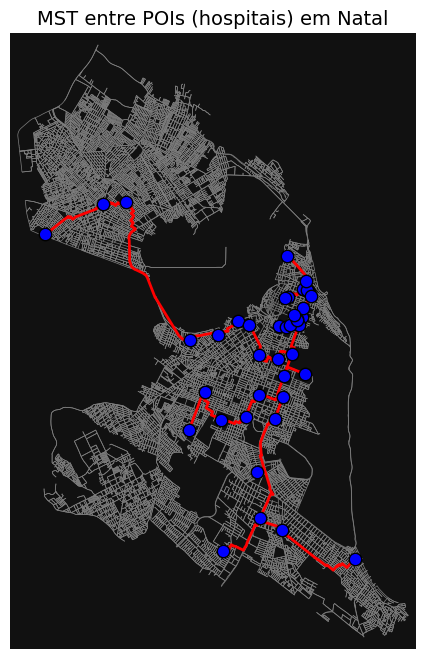

In [11]:
mst_routes = []
for (u, v, d) in mst_edges:
    route = nx.shortest_path(G_undirected, u, v, weight='length')
    mst_routes.append(route)

# Plotar o grafo base
fig, ax = ox.plot_graph(
    G_undirected, node_size=0, edge_color="gray", edge_linewidth=0.5, show=False, close=False
)

# Destacar as rotas do MST em vermelho
for route in mst_routes:
    x = [G_undirected.nodes[n]['x'] for n in route]
    y = [G_undirected.nodes[n]['y'] for n in route]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar também os POIs (hospitais) em azul
poi_x = [G_undirected.nodes[n]['x'] for n in hospital_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in hospital_nodes]
ax.scatter(poi_x, poi_y, c='blue', s=80, zorder=5, edgecolor='black')

plt.title("MST entre POIs (hospitais) em Natal", fontsize=14)
plt.show()